# Data quality checks

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [17]:
jhu_data = pd.read_csv("https://s3-us-west-1.amazonaws.com/starschema.covid/JHU_COVID-19.csv")
who_data = pd.read_csv("https://s3-us-west-1.amazonaws.com/starschema.covid/WHO_SITUATION_REPORTS.csv")

In [3]:
# papermill parameters
output_folder = '../docs/'

## WHO vs JHU country level data reconciliation

In [4]:
who_by_country_and_date = who_data.groupby(["ISO3166-1", "Date"]).aggregate({"Total_Cases": "sum",
                                                                             "Deaths": "sum"}).reset_index()
who_by_country_and_date["Date"] = pd.to_datetime(who_by_country_and_date["Date"])

In [5]:
jhu_deaths = jhu_data.loc[jhu_data["Case_Type"] == "Deaths"].groupby(["ISO3166-1", "Date"]).aggregate({"Cases": "sum"}).rename(columns={"Cases": "Deaths"})
jhu_cases = jhu_data.loc[jhu_data["Case_Type"] == "Confirmed"].groupby(["ISO3166-1", "Date"]).aggregate({"Cases": "sum"}).rename(columns={"Cases": "Total_Cases"})

In [6]:
jhu_pivoted = jhu_cases.join(jhu_deaths).reset_index()
jhu_pivoted["Date"] = pd.to_datetime(jhu_pivoted["Date"])

In [7]:
jhu_who_delta = who_by_country_and_date.merge(jhu_pivoted, on=["ISO3166-1", "Date"], suffixes=("_WHO", "_JHU"), how="outer")

In [8]:
jhu_who_delta["Delta_Total_Cases"] = abs(jhu_who_delta["Total_Cases_WHO"] - jhu_who_delta["Total_Cases_JHU"])
jhu_who_delta["Delta_Deaths"] = abs(jhu_who_delta["Total_Cases_WHO"] - jhu_who_delta["Total_Cases_JHU"])

In [9]:
jhu_who_delta = jhu_who_delta.merge(
    jhu_who_delta.groupby(["ISO3166-1", "Date"]).aggregate({
        "Delta_Total_Cases":
        "sum",
        "Delta_Deaths":
        "sum"
    }).rename(
        columns={
            "Delta_Total_Cases": "Total_Country_Delta_Cases",
            "Delta_Deaths": "Total_Country_Delta_Deaths"
        }).reset_index())

Since there are no comparator WHO reports pre-20MAR2020, prior values are filtered and discarded.

In [18]:
jhu_who_delta = jhu_who_delta.loc[jhu_who_delta["Date"] >= pd.Timestamp(year=2020, month=3, day=20)]

In [11]:
jhu_who_delta_cases = jhu_who_delta.sort_values(["Total_Country_Delta_Cases", "ISO3166-1", "Date"], ascending=False)
jhu_who_delta_cases = jhu_who_delta_cases[jhu_who_delta_cases["ISO3166-1"].isin(jhu_who_delta_cases["ISO3166-1"].unique()[0:16])]
jhu_who_delta_cases = jhu_who_delta_cases.pivot(index="ISO3166-1", columns="Date", values="Delta_Total_Cases")
jhu_who_delta_cases = jhu_who_delta_cases.sort_values(jhu_who_delta_cases.columns.max(), ascending=False)

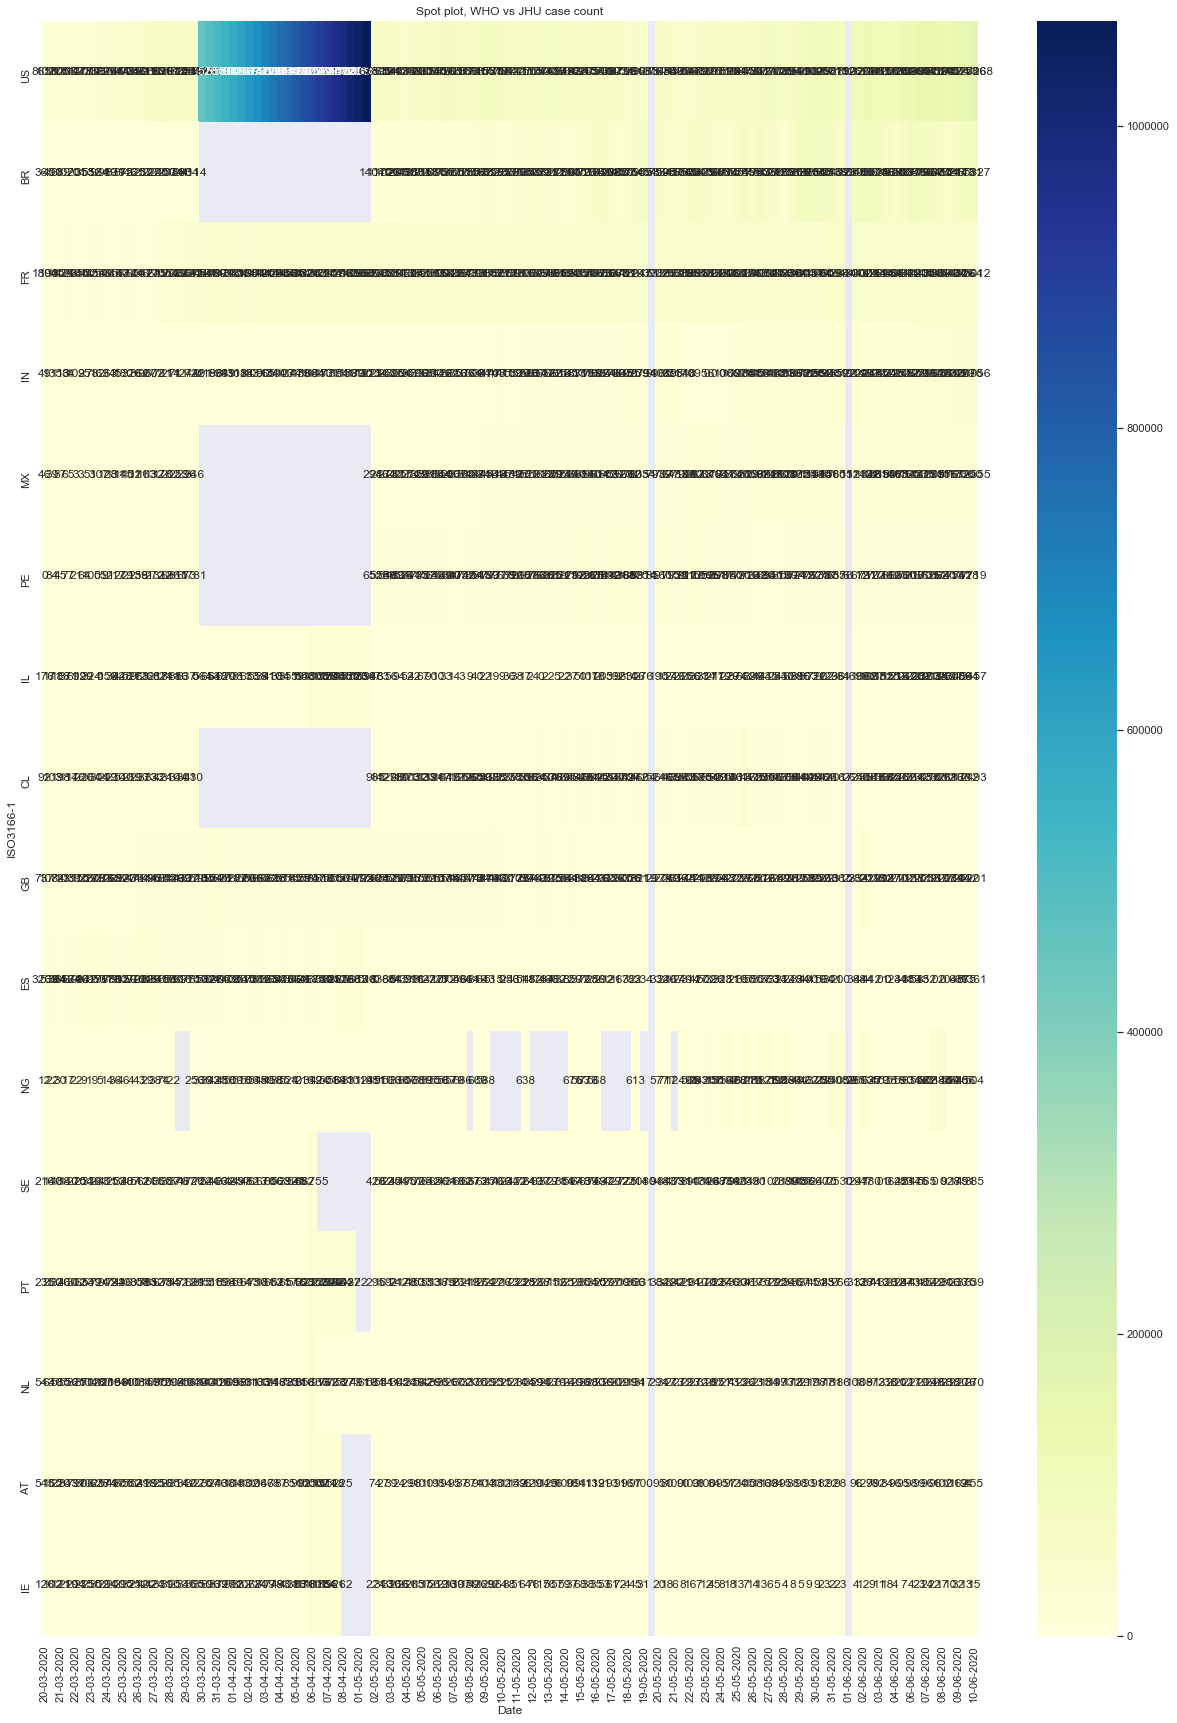

In [15]:
fig, ax = plt.subplots(figsize=(21, 29.7))
plt.title("Spot plot, WHO vs JHU case count")
sns.set()
ax = sns.heatmap(jhu_who_delta_cases, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_xticklabels(jhu_who_delta.loc[jhu_who_delta["Date"] >= pd.Timestamp(year=2020, month=3, day=20)]["Date"].dt.strftime('%d-%m-%Y'))
plt.xticks(rotation=90)
plt.savefig(output_folder + "dx_who_vs_jhu_case_count.png")

In [13]:
jhu_who_delta_deaths = jhu_who_delta.sort_values(["Total_Country_Delta_Cases", "ISO3166-1", "Date"], ascending=False)
jhu_who_delta_deaths = jhu_who_delta_deaths[jhu_who_delta_deaths["ISO3166-1"].isin(jhu_who_delta_deaths["ISO3166-1"].unique()[0:16])]
jhu_who_delta_deaths = jhu_who_delta_deaths.pivot(index="ISO3166-1", columns="Date", values="Delta_Total_Cases")
jhu_who_delta_deaths = jhu_who_delta_deaths.sort_values(jhu_who_delta_deaths.columns.max(), ascending=False)

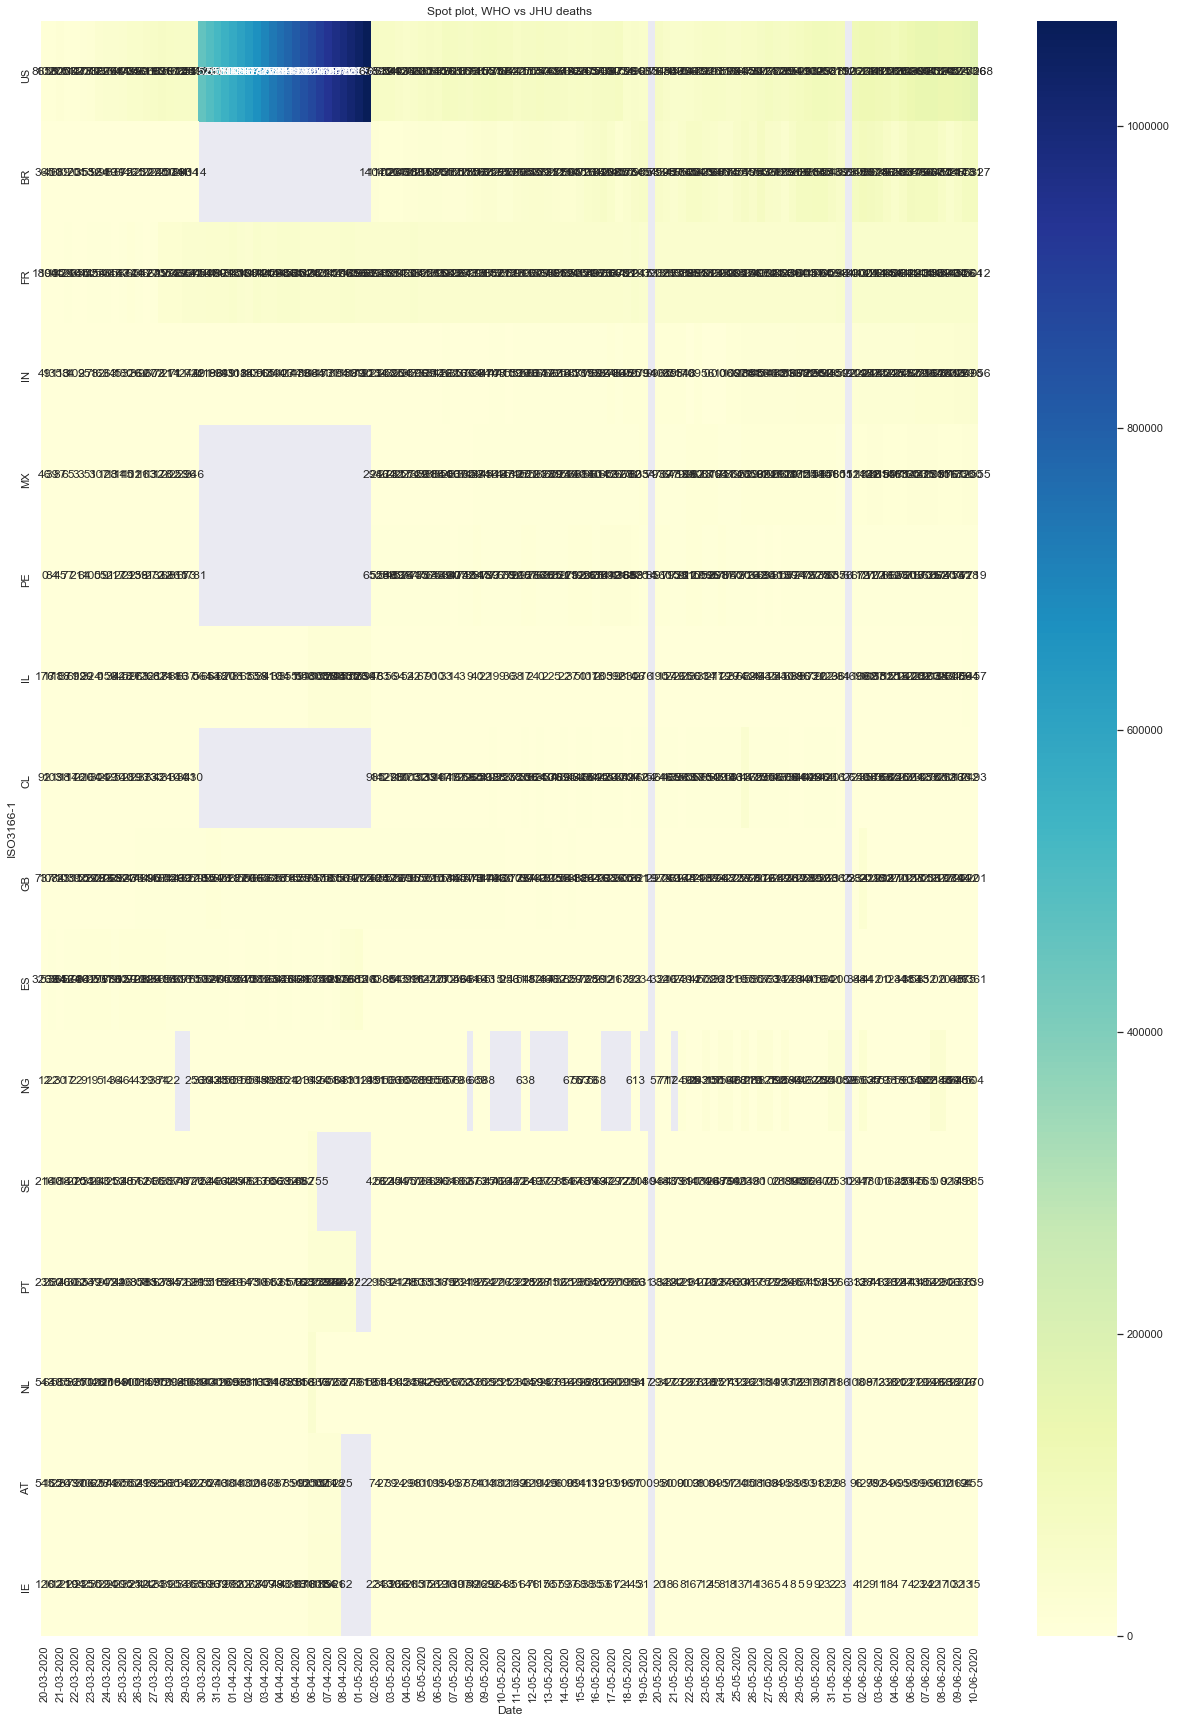

In [16]:
fig, ax = plt.subplots(figsize=(21, 29.7))
plt.title("Spot plot, WHO vs JHU deaths")
sns.set()
ax = sns.heatmap(jhu_who_delta_cases, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_xticklabels(jhu_who_delta.loc[jhu_who_delta["Date"] >= pd.Timestamp(year=2020, month=3, day=20)]["Date"].dt.strftime('%d-%m-%Y'))
plt.xticks(rotation=90)
plt.savefig(output_folder + "DQ_CHECKS_who_vs_jhu_deaths.png")